In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%load_ext autoreload
%autoreload 2

In [2]:
from requests_toolbelt import MultipartEncoder
from requests_toolbelt.multipart import decoder
import requests
import os
import json
from PIL import Image
import io

In [4]:
# this example notebook will process the first 8 images with filenames ending in .jpg or .JPG in this directory
sample_input_root = './sample_input'

ip_address = 'ottervm.eastus.cloudapp.azure.com'
port = '6002'
base_url = 'http://{}:{}/v1/camera-trap/detection-sync/'.format(ip_address, port)  # insert the IP address of the API
base_url

'http://ottervm.eastus.cloudapp.azure.com:6002/v1/camera-trap/detection-sync/'

# Tests for the Synchronous API

## Functional and bad requests

The regular example and too many images are tested using `example.ipynb`.

In [5]:
sample_input_dir = os.path.join(sample_input_root, 'test_images')

### Out of range confidence or render (boolean) values

In [6]:
num_images_to_upload = 2  # the /detect endpoint currently accepts a maximum of 8 images

detection_confidence = 1.1  # a value from 0 to 1
render_boxes = True  # True to have returned result contain annotated image files; in any case a json with result will be returned
# Any other value other than True, 'True', 'true' will be treated as False

params = {
    'confidence': detection_confidence,
    'render': render_boxes
}

files = {}

num_images = 0
for i, image_name in enumerate(sorted(os.listdir(sample_input_dir))):
    if not image_name.lower().endswith('.jpg'):
        continue
    
    if num_images >= num_images_to_upload:
        break
    else:
        num_images += 1
    
    img_path = os.path.join(sample_input_dir, image_name)
    files[image_name] = (image_name, open(img_path, 'rb'), 'image/jpeg')

print('number of images to send:', len(files))

r = requests.post(base_url + 'detect', 
                  params=params,
                  files=files)
r.status_code
r.ok
if not r.ok:
    r.reason
    r.text
r.elapsed.total_seconds()

number of images to send: 2


400

False

'BAD REQUEST'

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>400 Bad Request</title>\n<h1>Bad Request</h1>\n<p>Detection confidence 1.1 is invalid. Needs to be between 0.0 and 1.0.</p>\n'

1.184159

### Too many images

In [7]:
num_images_to_upload = 9  # the /detect endpoint currently accepts a maximum of 8 images

detection_confidence = 0.8  # a value from 0 to 1
render_boxes = True  # True to have returned result contain annotated image files; in any case a json with result will be returned

params = {
    'confidence': detection_confidence,
    'render': render_boxes
}

files = {}

num_images = 0
for i, image_name in enumerate(sorted(os.listdir(sample_input_dir))):
    if not image_name.lower().endswith('.jpg'):
        continue
    
    if num_images >= num_images_to_upload:
        break
    else:
        num_images += 1
    
    img_path = os.path.join(sample_input_dir, image_name)
    files[image_name] = (image_name, open(img_path, 'rb'), 'image/jpeg')

print('number of images to send:', len(files))

r = requests.post(base_url + 'detect', 
                  params=params,
                  files=files)
r.status_code
r.ok
if not r.ok:
    r.reason
    r.text
r.elapsed.total_seconds()

number of images to send: 9


413

False

'REQUEST ENTITY TOO LARGE'

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>413 Request Entity Too Large</title>\n<h1>Request Entity Too Large</h1>\n<p>Too many images. Maximum number of images that can be processed in one call is 8.</p>\n'

1.511907

In [20]:
content_length = 100 * (1024 * 1024)
'Payload size {:.2f} MB exceeds the maximum allowed of {} MB, or payload content length cannot\
        be determined. Please upload fewer images or more compressed images.'.format(
            content_length / (1024 * 1024), 2.4)

'Payload size 100.00 MB exceeds the maximum allowed of 2.4 MB, or payload content length cannot        be determined. Please upload fewer images or more compressed images.'

### Inputs with 0 images of the valid format according to the user provided request content type

In [9]:
params = {
    'confidence': 0.8,
    'render': True
}

files = {}

files['not an image'] = ('image_name', 'not an image content', 'content-type-not-image')

r = requests.post(base_url + 'detect', 
                  params=params,
                  files=files)

r.status_code
r.ok
if not r.ok:
    r.reason
    r.text
r.elapsed.total_seconds()

400

False

'BAD REQUEST'

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>400 Bad Request</title>\n<h1>Bad Request</h1>\n<p>No image(s) of accepted types (image/jpeg, image/png, application/octet-stream) received.</p>\n'

0.202117

### Inputs with image/jpeg as content type but are not really images

In [10]:
params = {
    'confidence': 0.8,
    'render': True
}

files = {}
sample_input_dir = os.path.join(sample_input_root, 'bad_inputs')

for i, image_name in enumerate(sorted(os.listdir(sample_input_dir))):
    if image_name.startswith('.'):
        continue
    print(image_name)
    img_path = os.path.join(sample_input_dir, image_name)
    files[image_name] = (image_name, open(img_path, 'rb'), 'image/jpeg')
    
print('Number of files:', len(files))

m = MultipartEncoder(fields=files)
print(m.content_type)

zPDF.pdf
Number of files: 1
multipart/form-data; boundary=f1b5814836b14bdf8045a5c8cf777a2f


In [11]:
r = requests.post(base_url + 'detect', 
                  params=params,
                  data=m,
                  headers={'Content-Type': m.content_type})
r.status_code
r.ok
if not r.ok:
    r.reason
    r.text
r.elapsed.total_seconds()

500

False

'INTERNAL SERVER ERROR'

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>Error reading the images: cannot identify image file &lt;FileStorage: \'zPDF.pdf\' (\'image/jpeg\')&gt;</p>\n'

0.25988

For a PDF, PIL will throw an error quickly. 

### PNG images (accepted)

In [12]:
params = {
    'confidence': 0.8,
    'render': True
}

files = {}
sample_input_dir = os.path.join(sample_input_root, 'png')

for i, image_name in enumerate(sorted(os.listdir(sample_input_dir))):
    if image_name.startswith('.'):
        continue
    print(image_name)
    img_path = os.path.join(sample_input_dir, image_name)
    files[image_name] = (image_name, open(img_path, 'rb'), 'image/jpeg')
    
print('Number of files:', len(files))

m = MultipartEncoder(fields=files)
print(m.content_type)

r = requests.post(base_url + 'detect', 
                  params=params,
                  data=m,
                  headers={'Content-Type': m.content_type})
r.status_code
r.ok
if not r.ok:
    r.reason
    r.text
r.elapsed.total_seconds()

S1_D04_R6_PICT0022.JPG
S1_D04_R6_PICT0022.png
S1_D04_R6_PICT0128.JPG
S1_D04_R6_PICT0128.png
Number of files: 4
multipart/form-data; boundary=3e1a0e0f7f7e4763b124ab1edc7713aa


200

True

3.747765

In [13]:
results = decoder.MultipartDecoder.from_response(r)
text_results = {}
images = {}
for part in results.parts:
    # part is a BodyPart object with b'Content-Type', and b'Content-Disposition', the later includes 'name' and 'filename' info
    headers = {}
    for k, v in part.headers.items():
        headers[k.decode(part.encoding)] = v.decode(part.encoding)
    if headers.get('Content-Type', None) == 'image/jpeg':
        #images[part.headers['filename']] = part.content
        c = headers.get('Content-Disposition')
        image_name = c.split('name="')[1].split('"')[0]  # somehow all the filename and name info is all in one string with no obvious forma
        image = Image.open(io.BytesIO(part.content))
        
        images[image_name] = image
    
    elif headers.get('Content-Type', None) == 'application/json':
        text_result = json.loads(part.content.decode())
text_result

{'S1_D04_R6_PICT0022.JPG': [[0.0,
   0.0,
   0.9414615035057068,
   1.0,
   0.9935316443443298],
  [0.0, 0.36560291051864624, 0.95051109790802, 1.0, 0.9623388648033142]],
 'S1_D04_R6_PICT0022.png': [[0.0,
   0.0,
   0.9414563179016113,
   1.0,
   0.9933851361274719],
  [0.0, 0.364469051361084, 0.9513617157936096, 1.0, 0.9631183743476868]],
 'S1_D04_R6_PICT0128.JPG': [[0.5866649746894836,
   0.02299772948026657,
   0.6697889566421509,
   0.17207273840904236,
   0.9988736510276794]],
 'S1_D04_R6_PICT0128.png': [[0.5866924524307251,
   0.022974886000156403,
   0.6697013974189758,
   0.17181673645973206,
   0.9988839030265808]]}

S1_D04_R6_PICT0022.JPG


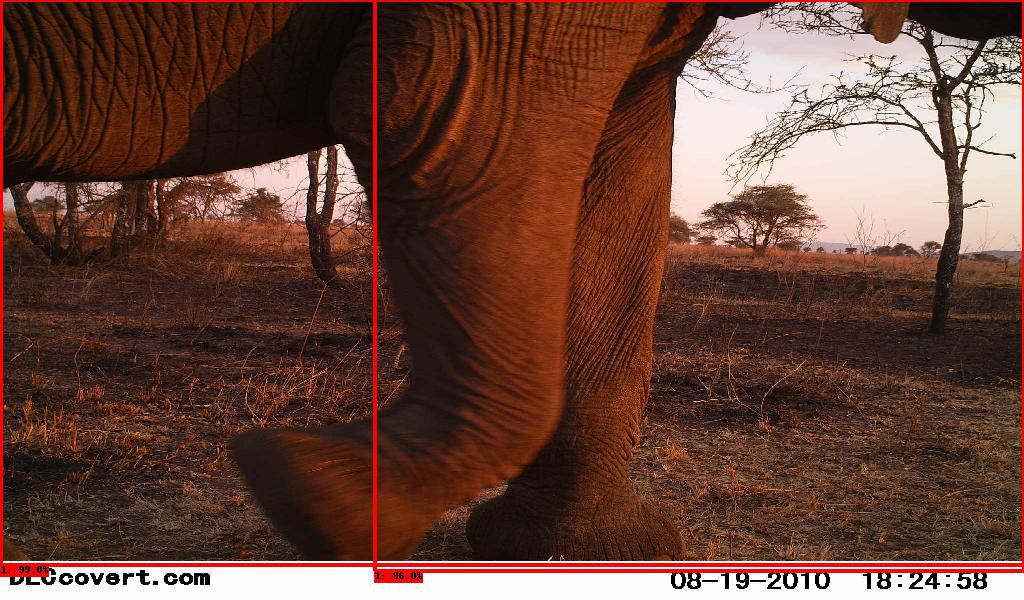


S1_D04_R6_PICT0022.png


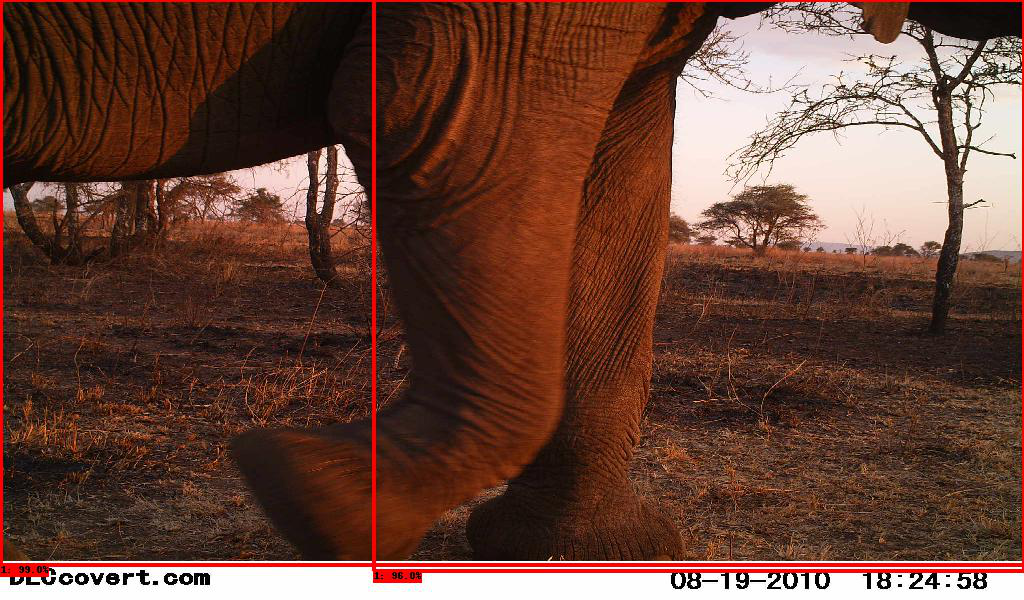


S1_D04_R6_PICT0128.JPG


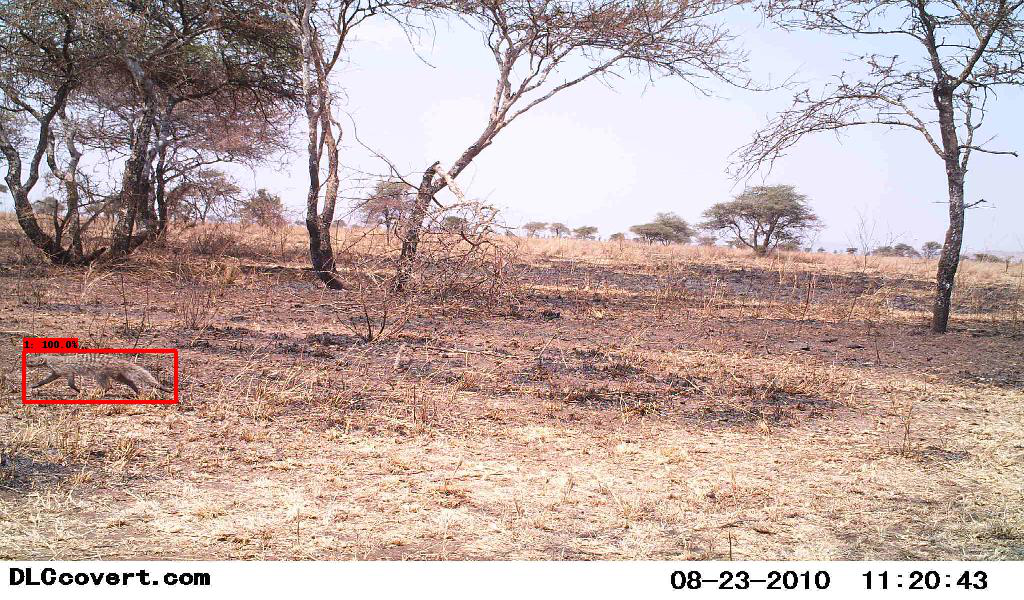


S1_D04_R6_PICT0128.png


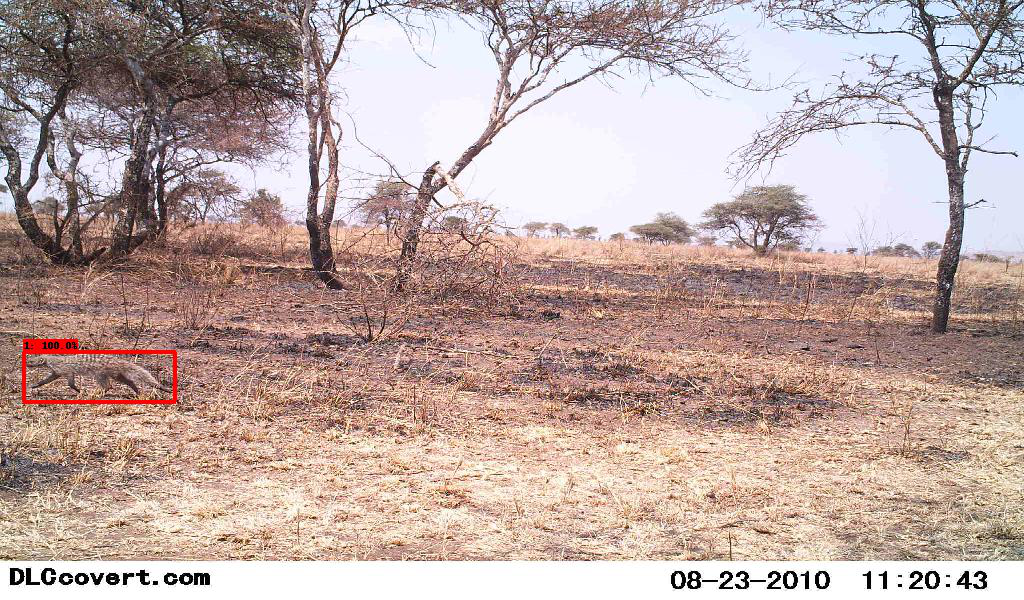

In [14]:
for img_name, img in sorted(images.items()):
    print(img_name)
    img
    print()

## Load

Reference: https://chriskiehl.com/article/parallelism-in-one-line

In [4]:
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from datetime import datetime
import sys

In [5]:
def call_api(args):
    url, params, data, headers = args['url'], args['params'], args['data'], args['headers']
    response = requests.post(url, params=params, data=data, headers=headers)
    return response

In [20]:
def test_load(num_requests, params, max_images=1):
    requests = []
    
    # read the images anew for each request
    for i in range(num_requests):    
        files = {}
        sample_input_dir = '/Users/siyuyang/Source/Repos/VSTS_AI4E/camera-trap-api/sync/example/sample_input/test_images'

        num_images = 0
        for i, image_name in enumerate(sorted(os.listdir(sample_input_dir))):
            if not image_name.lower().endswith('.jpg'):
                continue

            if num_images >= max_images:
                break
            else:
                num_images += 1

            img_path = os.path.join(sample_input_dir, image_name)
            with open(img_path, 'rb') as f:
                content = f.read()
            files[image_name] = (image_name, content, 'image/jpeg')

        m = MultipartEncoder(fields=files)
        args = {
            'url': base_url + 'detect',
            'params': params,
            'data': m,
            'headers': {'Content-Type': m.content_type}
        }
        requests.append(args)
    
    # images are read and in each request by the time we call the API in map()
    with ThreadPool(20) as pool:
        results = pool.map(call_api, requests)
        pool.close()
        pool.join()

    return results

In [21]:
params = {
    'confidence': 0.8,
    'render': True
}

num_requests = 1
max_images = 8

start = datetime.now()
responses = test_load(num_requests, params, max_images=max_images)
end = datetime.now()
total_time = end - start
print('Total time for {} requests: {}'.format(num_requests, total_time))

Total time for 1 requests: 0:00:06.276129


In [19]:
for r in responses:
    if not r.ok:
        r.reason
        r.text
    r.elapsed.total_seconds()

4.953534

In [9]:
results = decoder.MultipartDecoder.from_response(responses[0])

text_results = {}
images = {}
for part in results.parts:
    # part is a BodyPart object with b'Content-Type', and b'Content-Disposition', the later includes 'name' and 'filename' info
    headers = {}
    for k, v in part.headers.items():
        headers[k.decode(part.encoding)] = v.decode(part.encoding)
    if headers.get('Content-Type', None) == 'image/jpeg':
        #images[part.headers['filename']] = part.content
        c = headers.get('Content-Disposition')
        image_name = c.split('name="')[1].split('"')[0]  # somehow all the filename and name info is all in one string with no obvious forma
        image = Image.open(io.BytesIO(part.content))
        
        images[image_name] = image
    
    elif headers.get('Content-Type', None) == 'application/json':
        text_result = json.loads(part.content.decode())

In [ ]:
for img_name, img in sorted(images.items()):
    print(img_name)
    img
    print()